# Practice: Train a Neural Network on Spirals

In this notebook, you'll train a neural network on the **spirals** dataset!

**What is the spirals dataset?** Two interleaving spirals wound together - this is the **hardest** dataset shape for a neural network! It requires learning a very complex non-linear decision boundary.

---

## How This Notebook Works

- **Instructions** explain what to do
- **TODO** sections are for you to fill in
- **Hints** are available if you get stuck
- **Solutions** are hidden - try first before looking!

---

## Step 1: Setup - Imports

First, let's import the libraries we need.

Note: No sklearn import needed for spirals - we generate them manually!

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

print("Imports successful!")

Imports successful!


## Step 2: Copy Your Value Class

Copy the `Value` class from your summary notebook (003-summary_brief_of_micrograd.ipynb).

This is the foundation - we need it for automatic differentiation!

In [2]:
class Value:
	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
		
	def __repr__(self):
		return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
	
	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')
		def _backward():
			self.grad += out.grad
			other.grad += out.grad
		out._backward = _backward
		return out
	
	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')
		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward
		return out
	
	def __pow__(self, exponent):
		assert isinstance(exponent, (int, float)), "Only supporting int/float powers for now"
		out = Value(self.data ** exponent, (self,), f'**{exponent}')
		def _backward():
			self.grad += exponent * (self.data ** (exponent - 1)) * out.grad
		out._backward = _backward
		return out
	
	def __neg__(self):
		return self * -1
	
	def __sub__(self, other):
		return self + (-other)
	
	def __truediv__(self, other):
		return self * other**-1
	
	def __radd__(self, other):
		return self + other
	
	def __rsub__(self, other):
		return other + (-self)
	
	def __rmul__(self, other):
		return self * other

	def tanh(self):
		x = self.data
		t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
		out = Value(t, (self,), 'tanh')
		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward
		return out
	
	def exp(self):
		x = self.data
		out = Value(math.exp(x), (self,), 'exp')
		def _backward():
			self.grad += out.data * out.grad
		out._backward = _backward
		return out
	
	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)
		self.grad = 1.0
		for node in reversed(topo):
			node._backward()

## Step 3: Copy Your Neural Network Classes

Copy the `Neuron`, `Layer`, and `MLP` classes from your summary notebook.

In [3]:
class Neuron:
	def __init__(self, num_inputs):
		self.w = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
		self.b = Value(random.uniform(-1, 1))
	
	def __call__(self, x):
		activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
		return activation.tanh()
	
	def parameters(self):
		return self.w + [self.b]

class Layer:
	def __init__(self, num_inputs, num_outputs):
		self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

	def __call__(self, x):
		outputs = [neuron(x) for neuron in self.neurons]
		return outputs[0] if len(outputs) == 1 else outputs
	
	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
	def __init__(self, num_inputs, layer_sizes):
		sizes = [num_inputs] + layer_sizes
		self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(layer_sizes))]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

## Step 4: Generate the Spirals Dataset

Unlike the other datasets, spirals don't have a built-in sklearn function.
We create them manually using **polar coordinates**.

Two spirals are wound together, offset by pi radians.
This is the hardest shape for a neural network because the decision boundary must spiral around the origin.

In [4]:
# Generate two interleaving spirals manually
np.random.seed(42)
N = 100  # points per class (200 total - keep small for micrograd speed)
theta = np.linspace(0, 4 * np.pi, N)  # angle

# Spiral 1
r1 = theta + np.random.randn(N) * 0.3
x1 = r1 * np.cos(theta)
y1 = r1 * np.sin(theta)

# Spiral 2 (rotated by pi)
r2 = theta + np.random.randn(N) * 0.3
x2 = r2 * np.cos(theta + np.pi)
y2 = r2 * np.sin(theta + np.pi)

X = np.vstack([np.column_stack([x1, y1]), np.column_stack([x2, y2])])
y = np.hstack([np.ones(N), -np.ones(N)])

# IMPORTANT: Normalize! Spiral coordinates can be large (~-15 to 15)
# tanh saturates beyond ~2, so without normalization gradients vanish
X = (X - X.mean(axis=0)) / X.std(axis=0)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Unique labels: {np.unique(y)}")
print(f"Feature range after normalization: [{X.min():.2f}, {X.max():.2f}]")
print(f"First 5 points:\n{X[:5]}")
print(f"First 5 labels: {y[:5]}")

X shape: (200, 2)
y shape: (200,)
Unique labels: [-1.  1.]
Feature range after normalization: [-2.38, 2.40]
First 5 points:
[[0.02506694 0.00180144]
 [0.01271724 0.00393065]
 [0.07980981 0.02395556]
 [0.1459127  0.06308173]
 [0.06990837 0.04366689]]
First 5 labels: [1. 1. 1. 1. 1.]


## Step 5: Visualize the Data

Let's see what our data looks like!

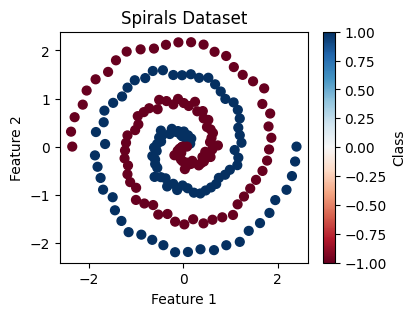

In [5]:
plt.figure(figsize=(4, 3))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', s=40)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Spirals Dataset')
plt.colorbar(label='Class')
plt.show()

## Step 7: Create the Neural Network

**Why `MLP(2, [16, 16, 16, 1])` for spirals? (3 hidden layers!)**

Spirals are the **hardest** dataset. The decision boundary isn't a line (blobs) or a circle (circles/gaussian) — it has to **twist and spiral** through the data multiple times. 

**Why 3 hidden layers instead of 2?**

Think of it as levels of abstraction:
- **Layer 1 (16 neurons)**: Learns basic features — "which side of these 16 lines is the point on?" These are raw linear cuts through the space.
- **Layer 2 (16 neurons)**: Combines lines into simple curves and regions — "is the point inside this wedge-shaped area?" 
- **Layer 3 (16 neurons)**: Combines those curves into **complex, twisting shapes** — "is the point in the spiraling region?" This is where the magic happens for spirals!
- **Output (1 neuron)**: Final decision.

**The depth matters because each layer adds a level of "compositionality":**
```
1 layer:  can learn lines          → good for blobs
2 layers: can learn simple curves  → good for circles
3 layers: can learn complex curves → needed for spirals
```

With only 2 layers, the network simply doesn't have the representational power to bend the decision boundary enough times. It's like trying to draw a spiral with only straight lines vs. using curves — you need more "bending ability."

**Why still 16 per layer, not 32?**
- With 100 points per class (200 total), a [32, 32, 32, 1] network would have ~2,000+ parameters — 10x more parameters than data points! That's a recipe for overfitting.
- 16 per layer gives 609 parameters — still more than our 200 data points, but the L2 regularization helps prevent overfitting.

**Honest expectation**: Even with 3 layers, spirals are SO hard that accuracy might only reach 50-70% with micrograd. Real deep learning frameworks (PyTorch, etc.) achieve ~95%+ by using:
- ReLU activation instead of tanh (avoids vanishing gradients in deep networks)
- Adam optimizer instead of plain gradient descent
- Thousands of iterations with learning rate scheduling

In [6]:
random.seed(17)
model = MLP(2, [32, 32, 16, 8, 1])

print(f"Model created!")
print(f"Total parameters: {len(model.parameters())}")

Model created!
Total parameters: 1825


## Step 8: Define the Loss Function

**Why hinge loss for spirals?**

We use **hinge loss**: `max(0, 1 - y * prediction)`

For spirals, the choice of loss function matters less than the architecture and optimization. But hinge loss is still a good choice:

1. **Focuses on the hard cases**: With spirals, many points are near the boundary where the two spirals interleave. Hinge loss naturally focuses gradient updates on these hard-to-classify boundary points (where margin < 1) and ignores the easy interior points (where margin ≥ 1).

2. **Gradient behavior with deep networks**: With 3 hidden layers, gradients have to flow through many tanh activations during backprop. Each tanh derivative `(1 - tanh²)` can shrink the gradient. Hinge loss helps because:
   - When a sample contributes to the loss, its gradient is simple and strong: just `-yi` times the chain of derivatives
   - When a sample is already correct (margin ≥ 1), its gradient is exactly 0 — no vanishing gradient problem for those samples

3. **L2 regularization is important here**: With 609 parameters and only 200 data points, the network could easily memorize the training data. `alpha=1e-4` penalizes large weights, encouraging the network to find a **smooth** spiraling boundary rather than a jagged one that overfits.

**The real challenge with spirals isn't the loss function — it's the optimization:**
- The loss landscape for spirals has many **local minima** (the network gets "stuck" in a so-so solution)
- Plain gradient descent can't escape these local minima easily
- That's why production neural networks use optimizers like Adam or SGD with momentum

In [7]:
def compute_loss(model, X, y, alpha=1e-4):
	# forward pass
	inputs = [list(row) for row in X]
	prediction = [model(x) for x in inputs]

	# calculate loss - Hinge loss
	losses = []
	for yi,pred in zip(y,prediction):
		margin = 1 + (-yi) * pred
		if margin.data > 0:
			losses.append(margin)
		else:
			losses.append(Value(0))
	avg_data_loss = sum(losses) * (1.0 / len(losses))
	reg_loss = alpha * sum(p*p for p in model.parameters())

	total_loss = avg_data_loss + reg_loss

	accuracy = sum(1 for yi, pred in zip(y, prediction) if (yi > 0) == (pred.data > 0)) / len(y)

	return total_loss, accuracy

## Step 9: The Training Loop!

**Why these hyperparameters?**

**`learning_rate = 1.0`** — For spirals, this is a balancing act:
- Too small (0.01): barely moves, gets stuck immediately, needs thousands of iterations
- Too large (5.0): overshoots, loss oscillates wildly, never converges
- 1.0 works as a reasonable middle ground with hinge loss + normalization
- In a real framework you'd use a **learning rate scheduler** that starts high and decreases over time

**`num_iteration = 200`** — More than other datasets because:
- The boundary is much more complex — the network needs more steps to "find" the spiral shape
- With 3 hidden layers, gradient updates are smaller (gradients shrink passing through each tanh layer — this is the **vanishing gradient problem**)
- 200 iterations is a compromise between training time and results with micrograd
- In real frameworks, you'd train for 1000+ iterations

**`N = 100` per class (200 total)** — Why keep it small?
- Each iteration runs 200 forward passes + 200 backward passes in pure Python
- With a 3-layer network (609 params), each pass builds a huge computation graph
- 200 samples × 200 iterations = 40,000 forward+backward passes total — already slow!
- With 500 samples it would be 100,000 passes — painfully slow in micrograd

**Normalization is essential here:**
- Spiral coordinates range from ~-15 to +15 (think: radius × cos/sin with radius up to 4π ≈ 12.6)
- tanh(15) ≈ 1.0000 with gradient ≈ 0.0000 — completely dead!
- After normalization: features in ~[-2, 2], tanh has healthy gradients, learning can actually happen

**What to expect:**
- Accuracy might plateau around 50-70% — that's normal for micrograd on spirals!
- If you get >60%, the network IS learning the spiral shape, just imperfectly
- Try running it multiple times with different `random.seed()` values — some initializations work much better than others

In [ ]:
learning_rate = 0.5
num_iteration = 200

print("Training...")
print("="*50)

for iteration in range(num_iteration):
    
    loss, accuracy = compute_loss(model, X, y)
    
    for p in model.parameters():
        p.grad = 0.0
        
    loss.backward()
    
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    
    if iteration % 20 == 0:
        print(f"Iteration {iteration:3d} | Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")
        

print("="*50)
print(f"Final - Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")

Training...
Iteration   0 | Loss: 0.9926 | Accuracy: 55.0%
Iteration  20 | Loss: 0.6937 | Accuracy: 68.5%


## Step 10: Visualize the Decision Boundary!

This is the coolest part - let's see what the network learned!

We'll:
1. Create a grid of points covering the plot area
2. Get the network's prediction for each point
3. Color the background based on predictions
4. Overlay the original data points

In [ ]:
def plot_decision_boundary(model, X, y):
	h = 0.25
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
						 np.arange(y_min, y_max, h))
	
	mesh_points = np.c_[xx.ravel(), yy.ravel()]
	Z = []
	for point in mesh_points:
		pred = model(list(point))
		Z.append(pred.data)
	Z = np.array(Z).reshape(xx.shape)
	
	plt.figure(figsize=(10, 8))
	plt.contourf(xx, yy, Z, levels=np.linspace(-1, 1, 20), cmap='RdBu', alpha=0.8)
	plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
	plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='black', s=50)
	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('Neural Network Decision Boundary')
	plt.colorbar(label='Prediction')
	plt.show()

plot_decision_boundary(model, X, y)

---

## Congratulations!

You've just trained a neural network on the spirals dataset - the hardest one!

**What you accomplished:**
- Generated a custom spirals dataset from scratch
- Built an MLP classifier from scratch
- Trained the network with gradient descent
- Visualized the learned decision boundary on spirals

**Note:** Spirals are extremely hard. If accuracy is low, try:
- Larger network: `MLP(2, [32, 32, 32, 1])`
- More iterations: `num_iteration = 300`
- Different learning rate

---